In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import shutil
import torch
import segmentation_models_pytorch as smp
from torch.optim.adamw import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
import getpass
import sys
curr_user = getpass.getuser()
sys.path.append(f'/home/{curr_user}/PycharmProjects/CSA_segmentation/')

In [3]:
from src._preprocess import clean, create_folders, preprocess, root_path
from src.data_extraction import get_dataloader_single_folder
from src.training import trainer
from src.inference import test
from src.visual import show_batch, show_test_result

**Очистка директории с предобработанными данными**

In [5]:
clean()
create_folders()

**Предобработка "сырых" фотографий**

In [6]:
slice_df = pd.read_csv(root_path / 'raw' / 'data.csv')
raw_df = pd.read_csv(root_path / 'raw' / 'photos_list.csv')
preprocess(raw_df, slice_df)

100%|██████████| 1168/1168 [02:48<00:00,  6.92it/s]


**Инициализация загрузчиков данных, модели, параметров обучения**

In [4]:
train = get_dataloader_single_folder(root_path / 'preprocessed_dataset')['Train']
valid = get_dataloader_single_folder(root_path / 'preprocessed_dataset')['Valid']
test_set = get_dataloader_single_folder(root_path / 'preprocessed_dataset')['Test']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = smp.Unet('efficientnet-b3', classes=1, activation='sigmoid', encoder_weights='imagenet')
model.to(device)


optimizer = AdamW(lr=1e-4, params=model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([3.5]))
IOU_metric = smp.utils.metrics.IoU(threshold=0.5, activation=None)

**Визуализация батчей в выбранном загрузчике**

Batch №0
torch.Size([4, 3, 768, 128]) torch.Size([4, 768, 128])
Images: 
 ['../data/preprocessed_dataset/photos/1017112_0.jpeg', '../data/preprocessed_dataset/photos/1002488_0.jpeg', '../data/preprocessed_dataset/photos/1002036_0.jpeg', '../data/preprocessed_dataset/photos/1016772_0.jpeg'],
 Masks: 
 ['../data/preprocessed_dataset/matrixes/1017112_0.npy', '../data/preprocessed_dataset/matrixes/1002488_0.npy', '../data/preprocessed_dataset/matrixes/1002036_0.npy', '../data/preprocessed_dataset/matrixes/1016772_0.npy']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


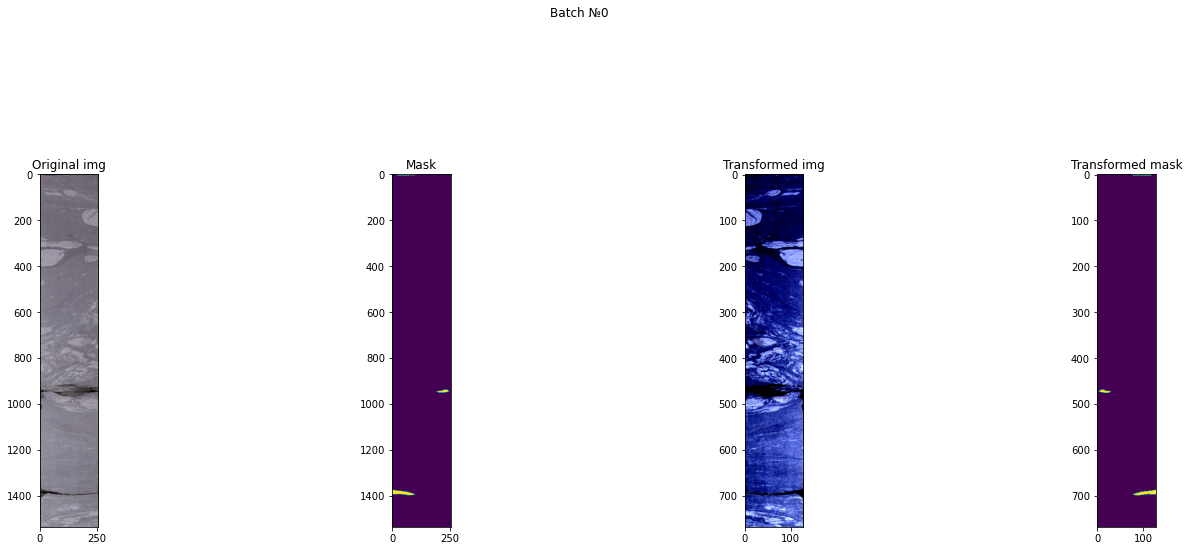

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


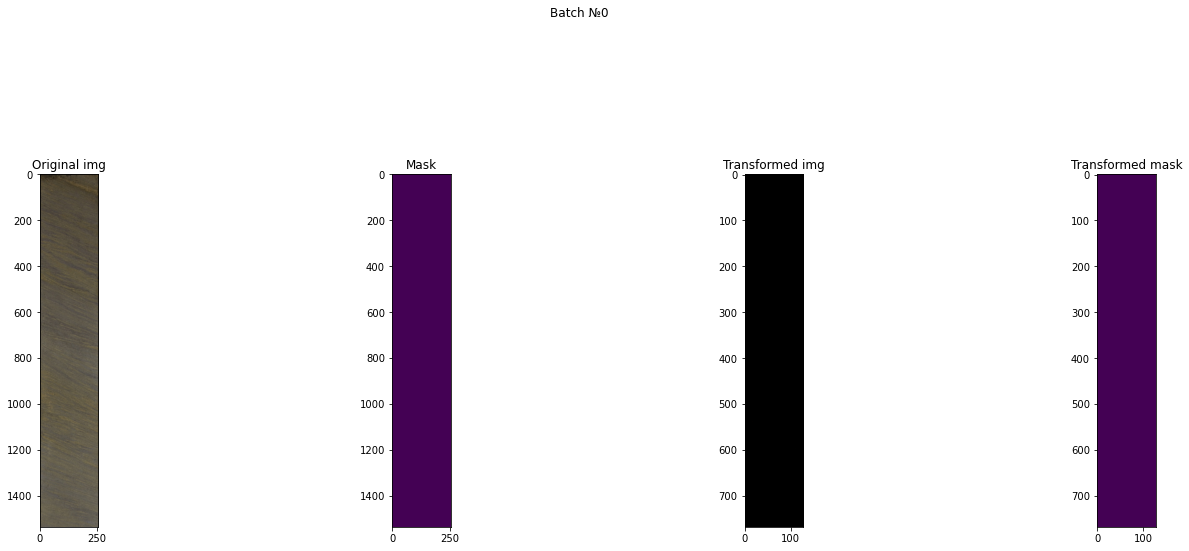

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


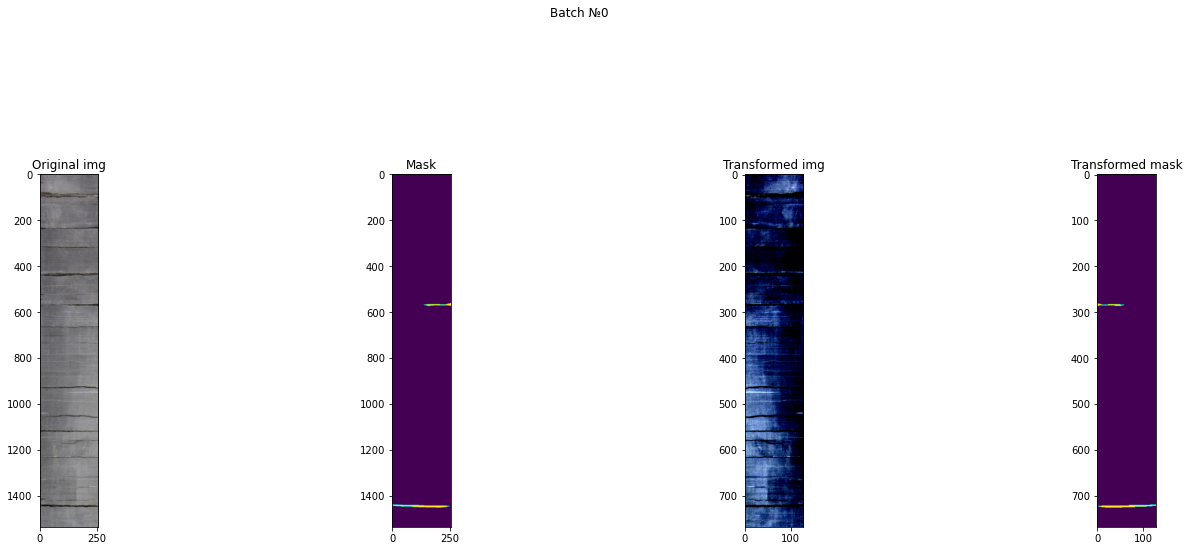

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


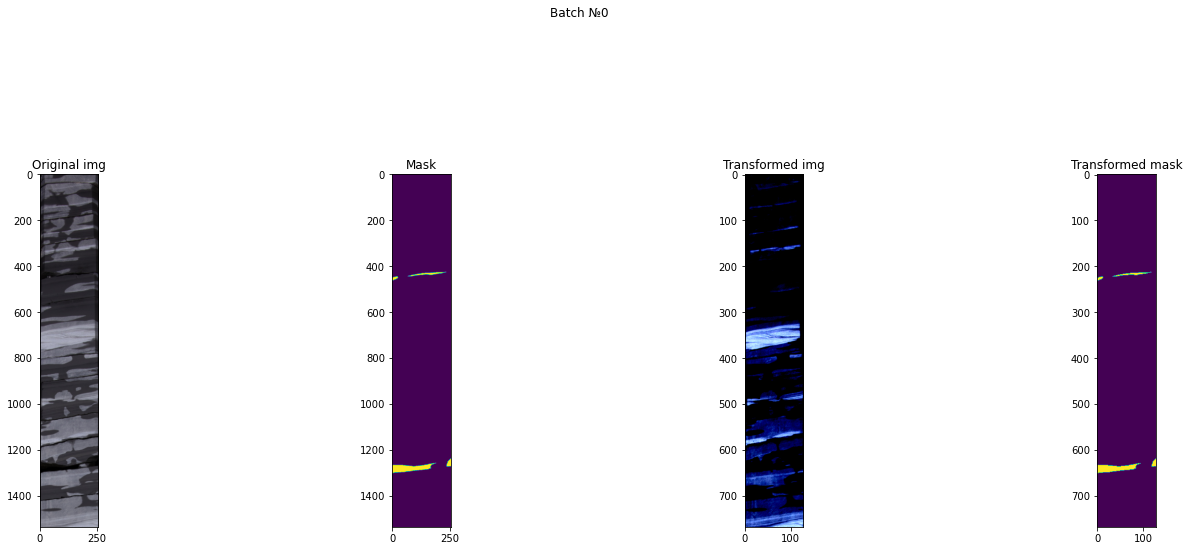

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch №1
torch.Size([4, 3, 768, 128]) torch.Size([4, 768, 128])
Images: 
 ['../data/preprocessed_dataset/photos/1006582_1.jpeg', '../data/preprocessed_dataset/photos/1016772_1.jpeg', '../data/preprocessed_dataset/photos/1004304_1.jpeg', '../data/preprocessed_dataset/photos/1001988_0.jpeg'],
 Masks: 
 ['../data/preprocessed_dataset/matrixes/1006582_1.npy', '../data/preprocessed_dataset/matrixes/1016772_1.npy', '../data/preprocessed_dataset/matrixes/1004304_1.npy', '../data/preprocessed_dataset/matrixes/1001988_0.npy']


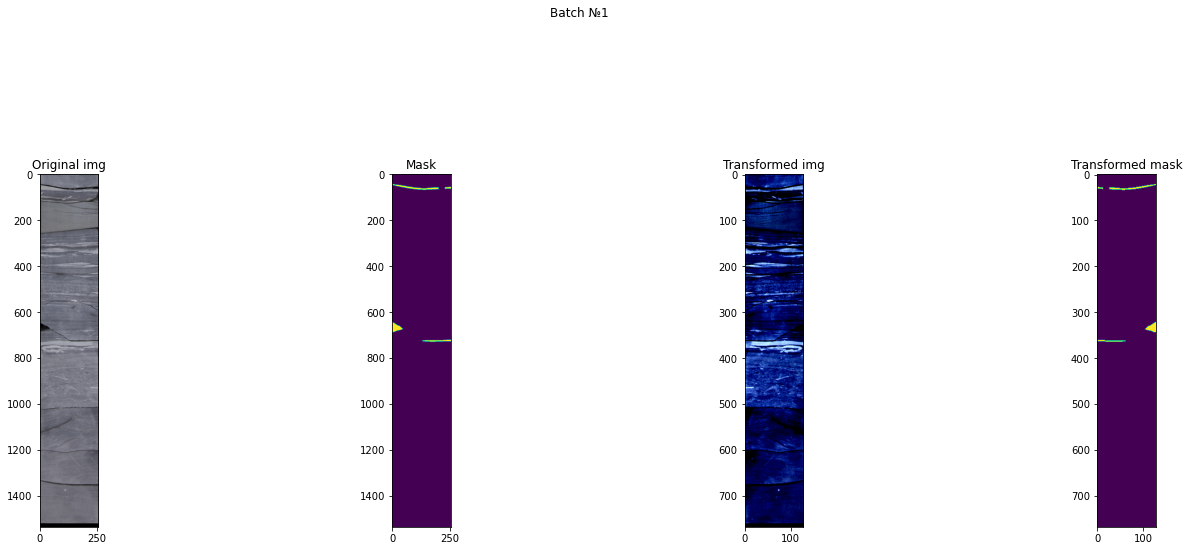

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


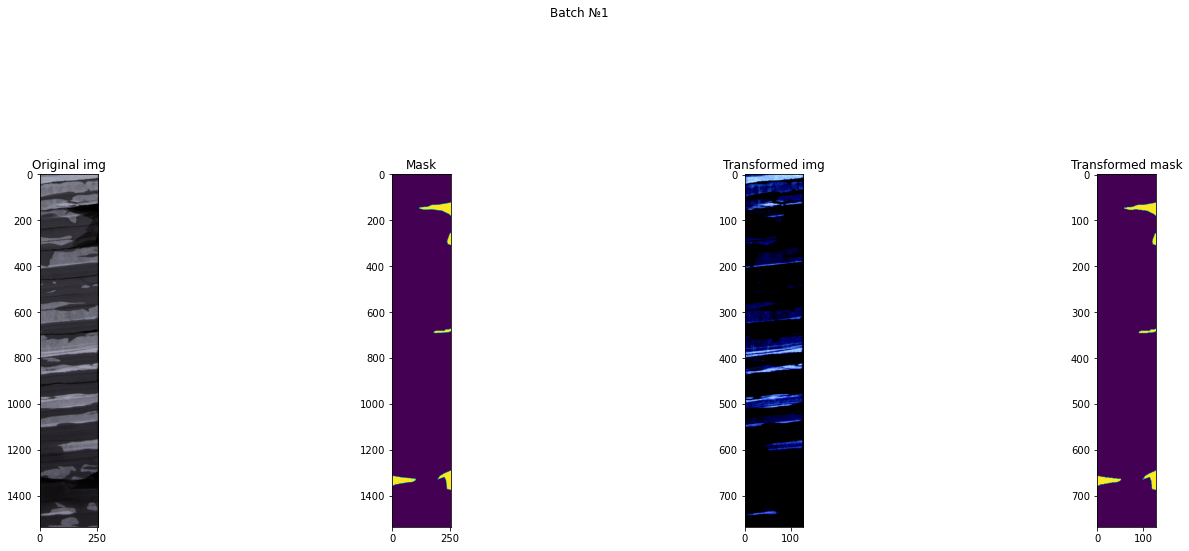

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


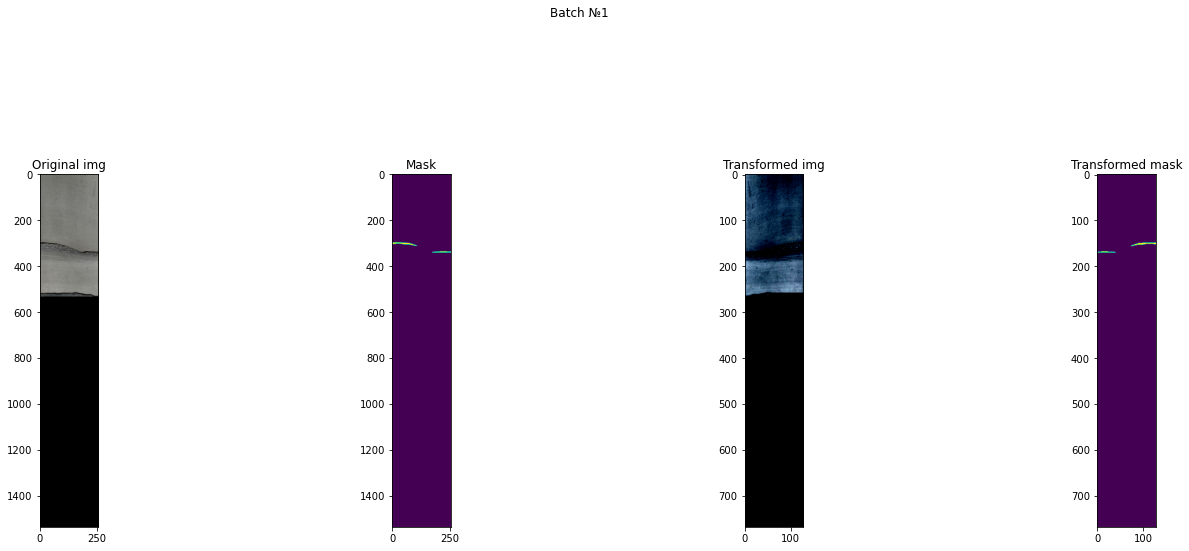

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


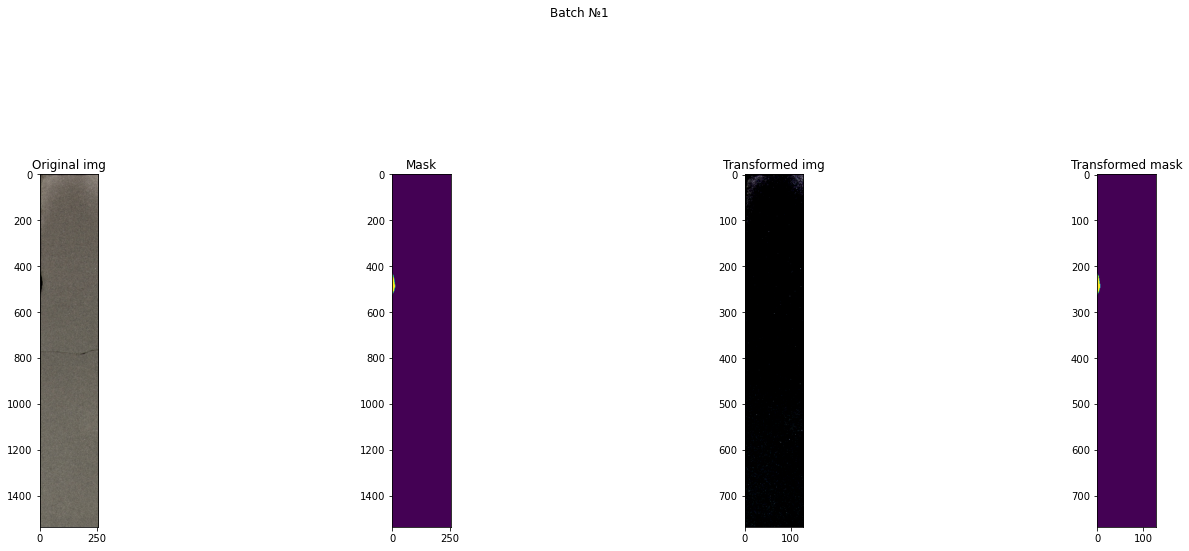

In [10]:
show_batch(train, 2)

**Обучение**

508it [03:09,  2.68it/s, train_loss=0.705]
64it [00:05, 12.33it/s, valid_loss=0.71, valid_metric=0.376]   


Epoch: 1  Training loss: 0.713900  Validation loss: 0.716744 Validation IoU Score: 0.535296
Validation loss decreased (inf --> 0.716744).  Saving model ...


364it [02:16,  2.67it/s, train_loss=0.734]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd9470f0c10>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd9470f0c10>
Traceback (most recent call last):
  File "/usr/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
  File "/usr/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 147, in join
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 147, in

Epoch: 2  Training loss: 0.712166  Validation loss: 0.715316 Validation IoU Score: 0.587839
Validation loss decreased (0.716744 --> 0.715316).  Saving model ...


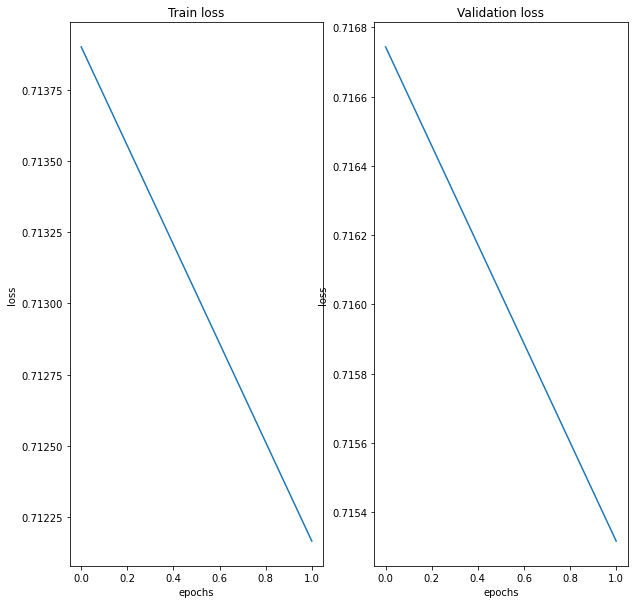

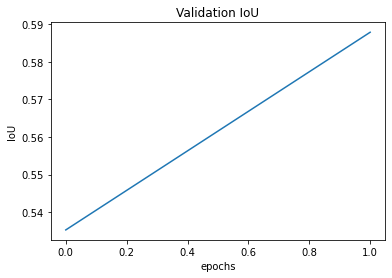

In [8]:
trainer(train, valid, device, model, optimizer, scheduler, criterion, 2, IOU_metric, True, '../models&weights/')

**Валидация модели на тестовой выборке**

In [ ]:
weights_path = Path('../models&weights')
model.load_state_dict(torch.load(weights_path / 'default_trainer_model.pt'))
model.to(device)
model.eval()

In [12]:
test(test_set, device, model, IOU_metric, root_path / 'result')

Overall test IoU: 0.30799212598425185


**Выход обученной сети на произвольной фотографии из тестовой выборки**

[0.18]


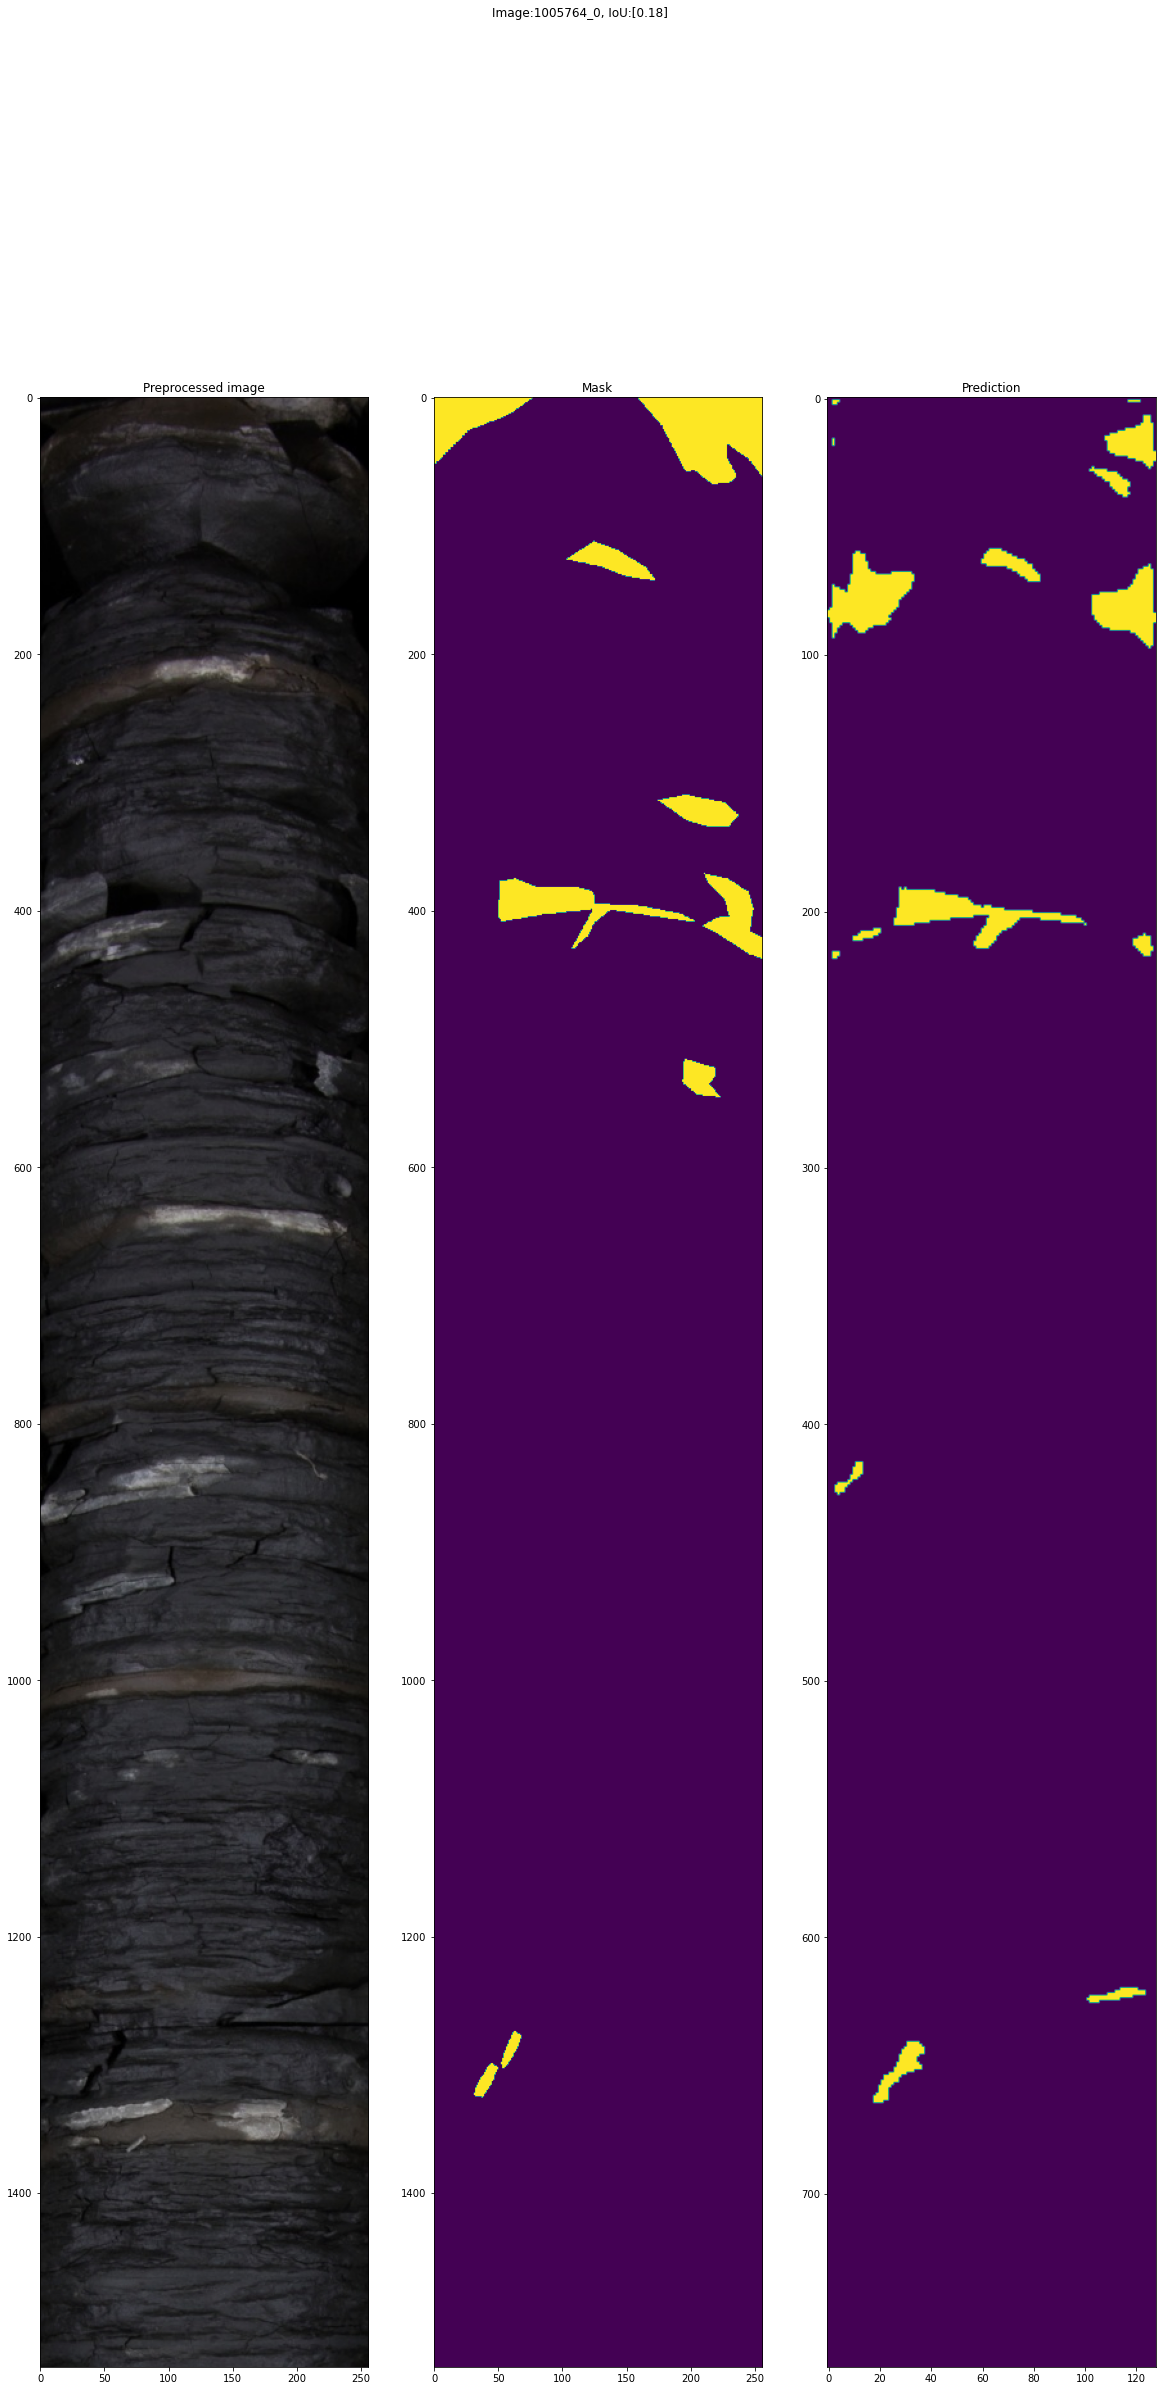

In [13]:
show_test_result('1005764_0')